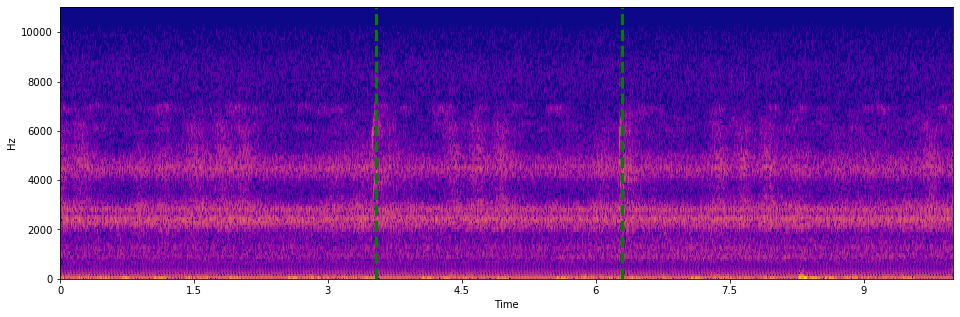

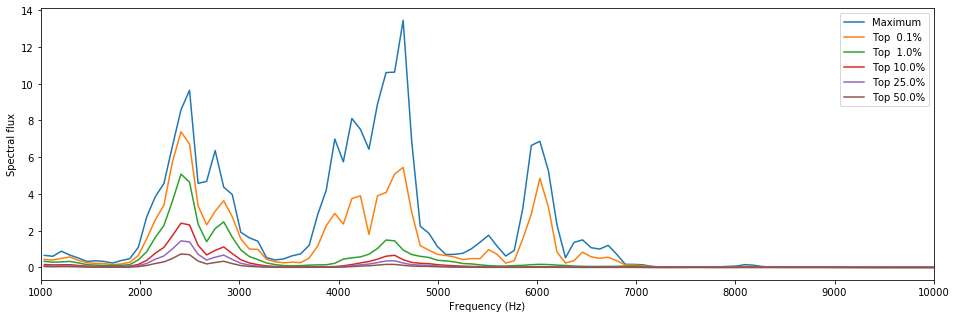

In [8]:
# Import dependencies
import librosa
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from librosa.display import specshow

# Define spectral flux
def spectral_flux(stft):
    return np.abs(np.diff(np.abs(stft)**2, axis=1))

# Define quantile summarization
def summarize(x, quantiles):
    return np.quantile(x, q=quantiles, axis=1).T

# Define pretty-printing function for quantiles
def quantile_to_str(q):
    if q==1.0:
        return "Maximum"
    else:
        return "Top {:4.1f}%".format((100 - q*100))

# Define constants
hop_length = 32
n_fft = 256
data_dir = '/Users/phinchosherpa/Desktop/nyu/'
n_required_calls = 2
quantiles = [1.0, 0.999, 0.99, 0.9, 0.75, 0.5]

# Parse CSV file
csv_name = 'BirdVox-DCASE-20k_csv-private.csv'
csv_path = os.path.join(data_dir, csv_name)
df = pd.read_csv(csv_path)

# Select a recording
row = df[df["#Calls"]==n_required_calls].iloc[0]
uuid_str = row["UUID"]

# Load the audio
wav_path = os.path.join(data_dir, 'wav', uuid_str + '.wav')
y, sr = librosa.load(wav_path)

# Load the timestamps
if n_required_calls > 0:
    timestamps_str = row["Call timestamps (s)"][1:-1]
    timestamps = [float(x[1:-1]) for x in timestamps_str.split(", ")]
else:
    timestamps = []

# Compute STFT
stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

# Compute spectral flux on the 1kHz - 11kHz range
fft_frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
fmin = 1000 # in Hertz
fmax = 11000 # in Hertz
bin_start = np.where(fft_frequencies>fmin)[0][0]
bin_stop = np.where(fft_frequencies<fmax)[0][-1]
features = spectral_flux(stft)
cropped_features = features[bin_start:bin_stop, :]
summarized_features = summarize(cropped_features, quantiles)

# Compute spectrogram for visualization
spectrogram = librosa.amplitude_to_db(np.abs(stft), top_db=70)


plt.figure(figsize=(16, 5))
specshow(spectrogram,
    cmap='plasma', y_axis='hz', sr=sr, hop_length=hop_length, x_axis='time')
for timestamp in timestamps:
    plt.plot([timestamp, timestamp], [0, sr], color='green', linewidth=3.0, linestyle='--')


plt.figure(figsize=(16, 5))
plt.plot(fft_frequencies[bin_start:bin_stop], summarized_features);
plt.xlim(1000, 10000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Spectral flux")
plt.legend(list(map(quantile_to_str, quantiles)))